In [1]:
# http://sceneparsing.csail.mit.edu/

In [2]:
# !pip install torch torchvision torchaudio matplotlib numpy opencv-python

In [ ]:
# from google.colab import drive
# import zipfile
# import os
# drive.mount('/content/drive')


# zip_path = "/content/drive/My Drive/ADEChallengeData2016.zip"
# extract_to = '/content/'

# os.makedirs(extract_to, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print(f"Files extracted to: {extract_to}")

Mounted at /content/drive
Files extracted to: /content/


In [32]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchvision.transforms import functional as TF

class ADE20KDataset(Dataset):
    def __init__(self, root_dir, types=None, transform=None, target_transform=None, resize=(256, 256)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resize = resize
        self.images = []
        self.masks = []

        img_dir = os.path.join(root_dir,'images', types)
        mask_dir = os.path.join(root_dir,'annotations', types)

#         img_files = sorted(os.listdir(img_dir))[:limit]
        img_files = sorted(os.listdir(img_dir))

        for img_name in img_files:
            self.images.append(os.path.join(img_dir, img_name))
            mask_name = img_name.replace('.jpg', '.png')
            self.masks.append(os.path.join(mask_dir, mask_name))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])

        image = TF.resize(image, self.resize)
        mask = TF.resize(mask, self.resize, interpolation=Image.NEAREST)



        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


transform = transforms.Compose([
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.PILToTensor()
])

train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = ADE20KDataset(root_dir='../ADEChallengeData2016', types="training", transform=train_transform, target_transform=target_transform, resize=(256, 256))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

val_dataset = ADE20KDataset(root_dir='../ADEChallengeData2016', types="validation", transform=transform, target_transform=target_transform, resize=(256, 256))
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


### Visualize the dataset

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])


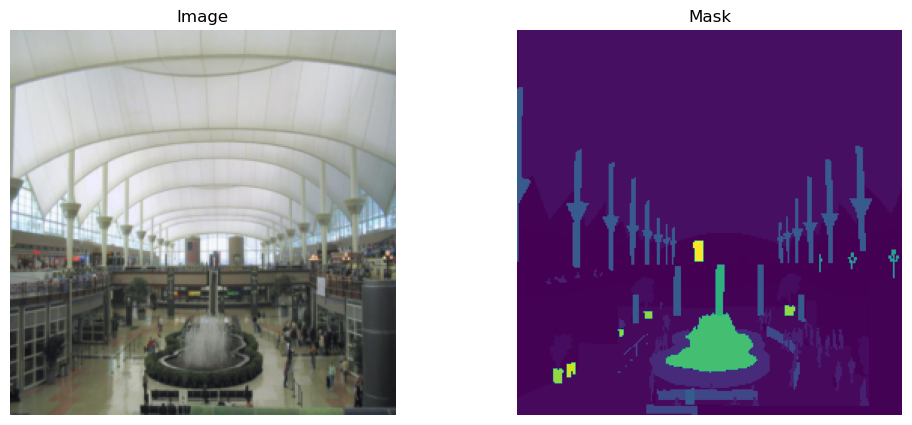

In [3]:
import matplotlib.pyplot as plt

visual_dataset = ADE20KDataset(root_dir='./ADEChallengeData2016', types="training", transform=transform, target_transform=target_transform, resize=(256, 256))
visual_loader = DataLoader(visual_dataset, batch_size=16, shuffle=False)
images, masks = next(iter(visual_loader))
print(images.shape, masks.shape)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0))
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze(0))
plt.title("Mask")
plt.axis('off')

plt.show()

In [8]:
import torchvision.models.segmentation as models

def create_fcn(num_classes):
    model = models.fcn_resnet101(weights="DEFAULT")
    model.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model.aux_classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))
    custom_weights = torch.load('./model_weights/model_weights2.pth')
    model.load_state_dict(custom_weights, strict=False)
    return model

fcn_model = create_fcn(num_classes=151)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcn_model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [5]:
import torchvision.models.segmentation as models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
def create_model(num_classes):
    model = models.deeplabv3_resnet101(pretrained=True,progress=True)
    model.classifier = DeepLabHead(2048, num_classes)
    model.aux_classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
    model.train()
    model.load_state_dict(torch.load('./model_weights/deepv3_model_p5.pth'))
    return model
deepv3_model = create_model(num_classes=151)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deepv3_model.to(device)

C:\Users\Aourbro\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Aourbro\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### Result from fine-tuned FCN resnet101 model

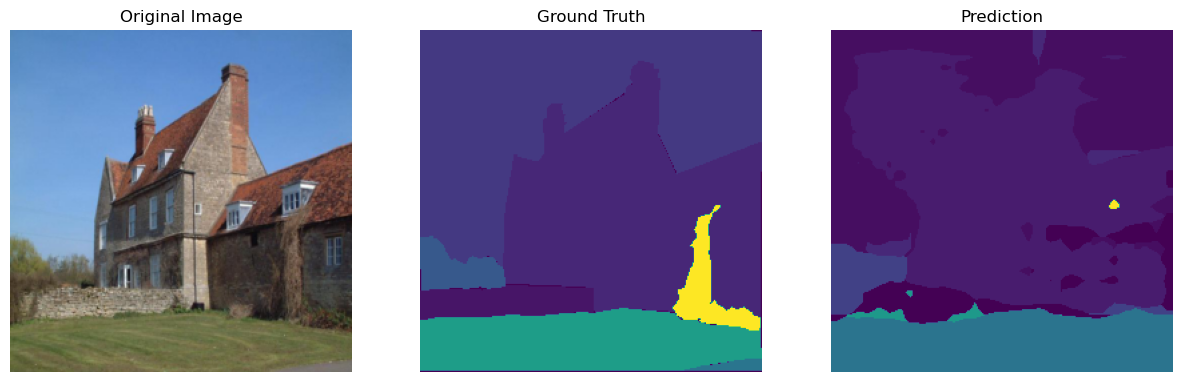

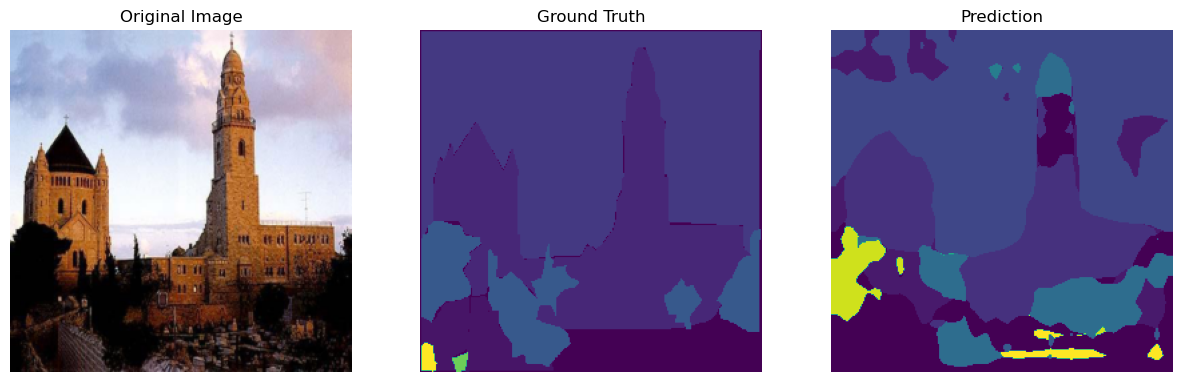

In [9]:
fcn_model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = fcn_model(images)['out']
        break
for i in range(2):
  sample_image, ground_truth, output = images[i], masks[i], outputs[i]
  visualize_segmentation(F.to_pil_image(sample_image), ground_truth, output)

### Result from fine-tuned deeplab-v3 resnet101 model

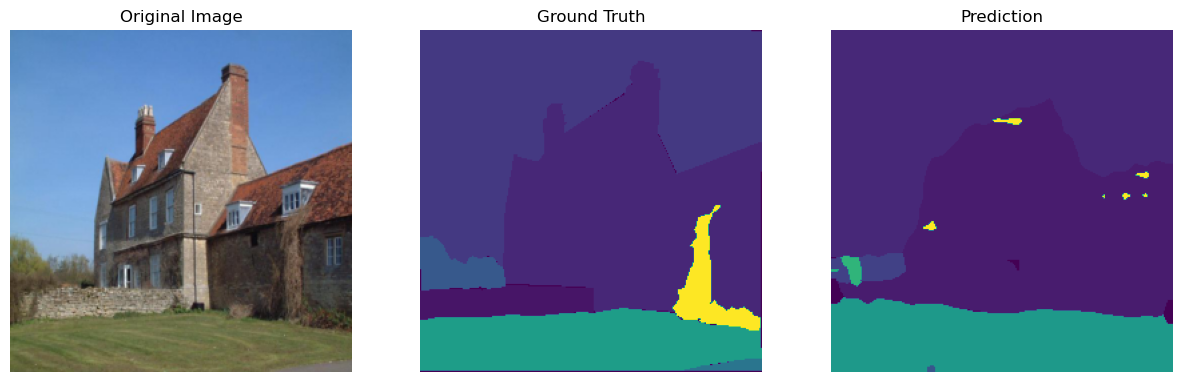

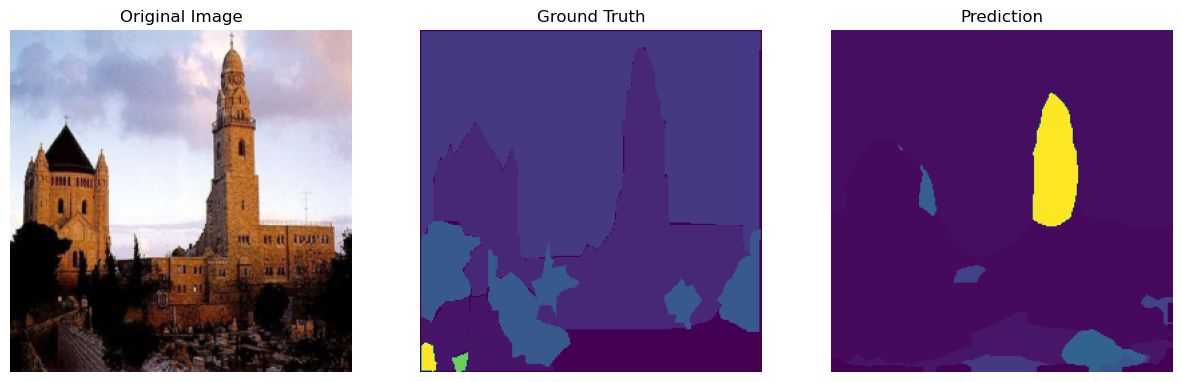

In [6]:
from torchvision.transforms import functional as F


def visualize_segmentation(sample_image, ground_truth, output):
    output = output.cpu().numpy()
    predicted = np.argmax(output, axis=0)

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth.permute(1, 2, 0))
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(output, axis=0))
    plt.title('Prediction')
    plt.axis('off')

    plt.show()

deepv3_model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = deepv3_model(images)['out']
        break
for i in range(2):
  sample_image, ground_truth, output = images[i], masks[i], outputs[i]
  visualize_segmentation(F.to_pil_image(sample_image), ground_truth, output)

### Result from fine-tuned resnet50dilated + ppm model

In [11]:
import os
repo_dir = r"C:\Users\Aourbro\Desktop\green_ratio"
os.chdir(repo_dir)

In [14]:
!pip install yacs 2>&1 >> install.log 
!git init 2>&1 >> install.log 
!git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
!git pull origin master 2>&1>> install.log
!DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

In [15]:
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='encoder_tuned.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='decoder_tuned.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
segmentation_module.to(device)

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [20]:
def visualize_result(img, pred, index=None):
    if index is not None:
        pred = np.where(pred == index, pred, -1)  # Filter to show only class of interest
        print(f'{names.get(index, "Unknown")}:')

    # Colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # Combine original image and colored prediction
    img_combined = np.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(img_combined))

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

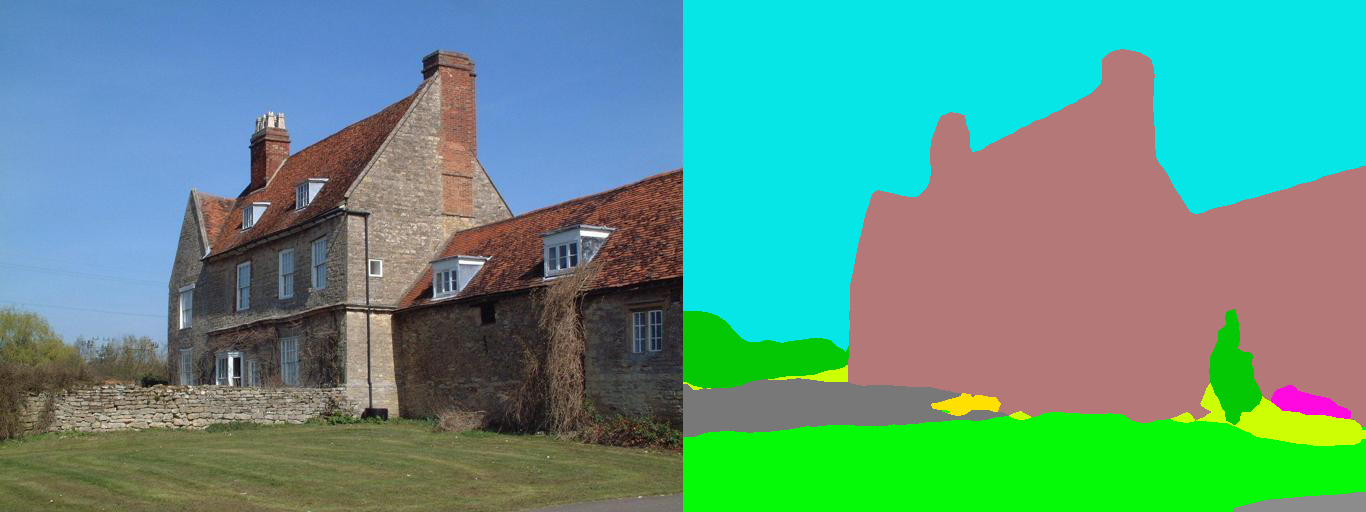

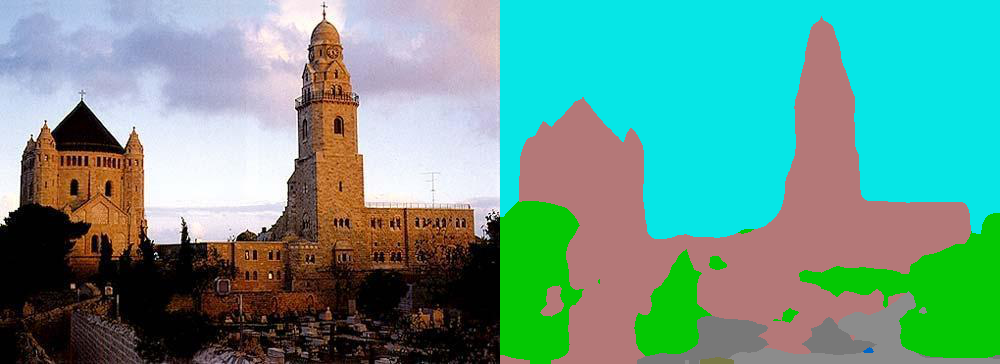

In [23]:
import matplotlib.pyplot as plt

def get_scores(img_path):
  pil_to_tensor = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225])
  ])
  pil_image = PIL.Image.open(img_path).convert('RGB')
  img_original = numpy.array(pil_image)
  img_data = pil_to_tensor(pil_image)
  singleton_batch = {'img_data': img_data[None].cuda()}
  output_size = img_data.shape[1:]

  with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)
      return scores, img_original

# Get the predicted scores for each pixel
scores, img_original = get_scores('../ADEChallengeData2016/images/validation/ADE_val_00000001.jpg')
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)
scores, img_original = get_scores('../ADEChallengeData2016/images/validation/ADE_val_00000002.jpg')
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

In [33]:
import torch
import numpy as np

def evaluation(model):
  considered_classes = [5, 10, 18, 30, 67]
  with torch.no_grad():
      for images, true_masks in val_loader:
          images = images.to(device)
          true_masks = true_masks.to(device)

          outputs = model(images)['out']
          predictions = torch.argmax(outputs, dim=1)

          # Squeeze in case the mask has an unnecessary dimension and flatten for comparison
          predictions = predictions.squeeze(1).flatten()
          true_masks = true_masks.squeeze(1).flatten()

          # Filter predictions and true_masks to only consider specific classes
          valid_preds_mask = np.isin(predictions.cpu().numpy(), considered_classes)
          valid_true_mask = np.isin(true_masks.cpu().numpy(), considered_classes)
          valid_both = valid_preds_mask & valid_true_mask  # Intersection where both conditions are true

          filtered_predictions = predictions.cpu().numpy()[valid_both]
          filtered_true_masks = true_masks.cpu().numpy()[valid_both]

          # Calculate pixel accuracy for the filtered predictions and true masks
          pixel_accuracy = np.mean(filtered_predictions == filtered_true_masks)

          # Calculate IoUs (Intersection over Union) for the considered classes
          ious = []
          for class_value in considered_classes:
              intersection = np.logical_and(filtered_predictions == class_value, filtered_true_masks == class_value).sum()
              union = np.logical_or(filtered_predictions == class_value, filtered_true_masks == class_value).sum()

              if union == 0:
                  ious.append(float('nan'))  # Avoid division by zero and handle non-present classes
              else:
                  ious.append(intersection / union)

          mean_iou = np.nanmean(ious) if np.any(np.isnan(ious)) else np.mean(ious)
          return pixel_accuracy, mean_iou

deepv3_model.eval()
deepv3_pixel_acc, deepv3_mean_iou = evaluation(deepv3_model)
print(f"Green Pixel Accuracy of deepv3_model: {deepv3_pixel_acc:.4f}")
print(f"Mean IoU for green classes of deepv3_model: {deepv3_mean_iou:.4f}")

Green Pixel Accuracy of deepv3_model: 0.5614
Mean IoU for green classes of deepv3_model: 0.3534


In [52]:
fcn_model.eval()
fcn_pixel_acc, fcn_mean_iou = evaluation(fcn_model)
print(f"Green Pixel Accuracy of fcn_model: {fcn_pixel_acc:.4f}")
print(f"Mean IoU for green classes of fcn_model: {fcn_mean_iou:.4f}")

Green Pixel Accuracy of fcn_model: 0.3105
Mean IoU for green classes of fcn_model: 0.4124


In [50]:
import os
import PIL.Image
import numpy as np
import torch
import torchvision.transforms as transforms

def get_scores2(img_path, model, device):
    pil_to_tensor = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225])
    ])
    pil_image = PIL.Image.open(img_path).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)
        _, predictions = torch.max(scores, dim=1)
        return predictions

def evaluate_folder(folder_path, model, device, green_class_ids):
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]
    green_accuracies = []
    mean_ious = []

    for file_path in files:
        predictions = get_scores2(file_path, model, device)
        predictions = predictions.cpu()[0].numpy()
        predictions+=1

        # Assuming true_masks are available, load them similarly to predictions if they're in a parallel directory or format
        true_mask_path = file_path.replace('images', 'annotations').replace('.jpg', '.png')
        true_mask = PIL.Image.open(true_mask_path)
        true_mask = np.array(true_mask)

        # Calculate accuracy only for the specific green classes
        valid_mask = np.isin(true_mask, green_class_ids)
        valid_predictions = np.isin(predictions, green_class_ids)
        correct_predictions = np.logical_and(predictions == true_mask, valid_mask)
        green_accuracy = np.sum(correct_predictions) / np.sum(valid_mask) if np.sum(valid_mask) != 0 else 0
        green_accuracies.append(green_accuracy)

        # IoU calculations for all classes present in the mask
        present_classes = np.unique(true_mask)
        ious = []
        for cls in present_classes:
            intersection = np.logical_and(predictions == cls, true_mask == cls).sum()
            union = np.logical_or(predictions == cls, true_mask == cls).sum()
            if union != 0:
                ious.append(intersection / union)

        mean_iou = np.nanmean(ious) if ious else float('nan')
        mean_ious.append(mean_iou)
#         print(f"Processed {file_path}: Green Class Accuracy = {green_accuracy:.4f}, Mean IoU = {mean_iou:.4f}")

    # Average scores over all images
    avg_green_accuracy = np.mean(green_accuracies)
    avg_mean_iou = np.mean(mean_ious)
    return avg_green_accuracy, avg_mean_iou


# Specify the folder and green classes
folder_path = '../ADEChallengeData2016/images/validation'
green_class_ids = [5, 10, 18, 30, 67]
avg_green_accuracy, avg_mean_iou = evaluate_folder(folder_path, segmentation_module, 'cuda', green_class_ids)

In [51]:
print(f"Average Green Class Accuracy: {avg_green_accuracy:.4f}")
print(f"Average Mean IoU: {avg_mean_iou:.4f}")

Average Green Class Accuracy: 0.7138
Average Mean IoU: 0.5311


### Fine-tuning procedure

In [54]:
import torch.optim as optim
# from torch.nn import functional as F

# fcn_model.to(device)
# segmentation_module.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deepv3_model.to(device)

optimizer = optim.Adam([
    {'params': deepv3_model.classifier.parameters(), 'lr': 1e-4},
    {'params': deepv3_model.aux_classifier.parameters(), 'lr': 1e-4}
], lr=1e-4)

criterion = torch.nn.CrossEntropyLoss()

In [55]:
epochs = 15

# change the model name below to fine-tune different models
def finetune(model):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.squeeze(1).to(device)

            optimizer.zero_grad()

            outputs = model(images)['out']
            loss = criterion(outputs, masks.long())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}")

finetune(deepv3_model)
# finetune(fcn_model)
# finetune(segmentation_module)

Epoch 1, Loss: 1.7813078810612615
Epoch 2, Loss: 1.7305338934968455
Epoch 3, Loss: 1.719526303081086
Epoch 4, Loss: 1.7017672027642734
Epoch 5, Loss: 1.6871425888408869
Epoch 6, Loss: 1.6802803933049162
Epoch 7, Loss: 1.6512415540484955
Epoch 8, Loss: 1.6486371936508641
Epoch 9, Loss: 1.6407628668763767
Epoch 10, Loss: 1.6315194591165731
Epoch 11, Loss: 1.627700080505956
Epoch 12, Loss: 1.614067930002182
Epoch 13, Loss: 1.595772835012442
Epoch 14, Loss: 1.5906396757680388
Epoch 15, Loss: 1.5755175911961272


In [ ]:
# torch.save(fcn_model.state_dict(), 'fcn_model_ade20k_finetuned.pth')
# torch.save(deepv3_model.state_dict(), './model_weights/deepv3_model_p5.pth')